In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import cv2 as cv
# from scipy.ndimage.filters import sobel
from scipy.ndimage import sobel

import pathlib
from dotenv import load_dotenv

from ipywidgets import interact, widgets
from plotly.express import imshow as imshow_interactive
from tqdm.notebook import tqdm

In [2]:
import numpy_indexed as npi

In [3]:
from template_match import read_image_rgb, read_image_gray, template_match, detect_points, find_tolerance_limit, simplify_points, agglomerative_clustering, meanshift_clustering, invert_convolution_map, point_to_bbox, \
    replace_black_pixels

from process_template import template_tresholding, reconstruct_template_mask

from hough_transform import calc_gradients, build_hough_model, fill_accumulator, \
    normalize_map, get_first_N_maximums

In [4]:
def draw_image(image: np.ndarray) -> None:
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))


def draw_points_on_canvas(points: np.ndarray, image: np.ndarray) -> None:
    x = points[:, 0]
    y = points[:, 1]
    
    clear_canvas = image.copy()
    clear_canvas[:, :] = 255
    plt.scatter(x, y, alpha=0.5, s=5)
    plt.imshow(cv.cvtColor(clear_canvas, cv.COLOR_BGR2RGB))

In [5]:

from matplotlib.patches import Rectangle

def draw_bbox(x_min, x_max, y_min, y_max, bbox_center=None) -> None:
    height = y_max - y_min
    width = x_max - x_min
    rect = Rectangle((x_min, y_min), width, height, edgecolor='r', facecolor='none')
    ax = plt.gca()
    ax.add_patch(rect)

    if bbox_center:
        bbox_center_x, bbox_center_y = bbox_center
        plt.scatter([bbox_center_x], [bbox_center_y], marker="*")

In [6]:
BASE_DIR = pathlib.Path(__name__).resolve().parent.parent
load_dotenv(BASE_DIR / '.env')
DATA_PATH = pathlib.Path(os.getenv("DATA_PATH"))

In [7]:
def get_image_part(y: int, x: int, image: np.ndarray, w: int, h: int):
    return image[y : y+h, x : x+w]

def sqdiff(image_part: np.ndarray, template: np.ndarray):
    sqdiff_sum = np.sum((image_part.astype(np.float64) - template.astype(np.float64))**2)
    return sqdiff_sum


def sqdiff_normed(image_part: np.ndarray, template: np.ndarray, mask: np.ndarray) -> float:
    """
    OpenCV SQDIFF_NORMED implementation
    """
    image_part = image_part.astype(np.float64)
    template = template.astype(np.float64)
    mask = mask.astype(np.float64)

    sqdiff = np.sum( ((template - image_part) * mask)**2 )
    norm1 = np.sum( (template * mask)**2 )
    norm2 = np.sum( (image_part * mask)**2 )

    sqdiff_normed = sqdiff / np.sqrt(norm1 * norm2)

    return sqdiff_normed


def compute_mask_pixel_ratio(image_part: np.ndarray, template_mask: np.ndarray, image_mask_value: float):
    
    image_mask_indexes = np.where((image_part[:, :, 0] == image_mask_value) & (image_part[:, :, 1] == image_mask_value) & (image_part[:, :, 2] == image_mask_value))
    template_non_mask_indexes = np.where(template_mask != 0)

    x, y = image_mask_indexes
    image_part_mask_pixel_coords = np.stack((x, y)).T

    x1, y1 = template_non_mask_indexes
    template_non_mask_pixel_coords = np.stack((x1, y1)).T

    true_mask_pixel_coords = npi.intersection(
        image_part_mask_pixel_coords,
        template_non_mask_pixel_coords
    )

    mask_pixel_ratio = len(true_mask_pixel_coords) / len(template_non_mask_pixel_coords)
    
    return mask_pixel_ratio


def compute_mask_pixel_ratio_v2(
    image_mask_part_binary: np.ndarray,
    template_mask_binary: np.ndarray,
    template_non_mask_pixels_count: int
) -> float:
    """
    Return count of non mask pixels of 
    """
    return np.sum(image_mask_part_binary * template_mask_binary) / template_non_mask_pixels_count



def sqdiff_normed_modification(
    image_part: np.ndarray,
    template: np.ndarray, 
    template_mask_rgb: np.ndarray,
    image_mask_part_binary: np.ndarray,
    template_mask_binary: np.ndarray,
    template_non_mask_pixels_count: int,
    ratio_treshold: float = 0.5
) -> float:
    """
    SQDIFF_NORMED modification
    """
    mask_pixel_ratio = compute_mask_pixel_ratio_v2(
        image_mask_part_binary, 
        template_mask_binary,
        template_non_mask_pixels_count
    )
    if mask_pixel_ratio < ratio_treshold:
        return np.nan

    sqdiff = np.sum( ((template - image_part) * template_mask_rgb)**2 )
    norm1 = np.sum( (template * template_mask_rgb)**2 )
    norm2 = np.sum( (image_part * template_mask_rgb)**2 )

    sqdiff_normed = sqdiff / np.sqrt(norm1 * norm2)

    return sqdiff_normed


def cv_sqdiff_normed(iamge_part: np.ndarray, template: np.ndarray, mask: np.ndarray):

    sqdiff = cv.matchTemplate(iamge_part, template, cv.TM_SQDIFF_NORMED, mask=mask)
    return sqdiff

## Convolution implementation

In [62]:
PLOT_NUMBER = 6
MARKER_NUMBER = 3

PLOT_PATH = DATA_PATH / f"plot{PLOT_NUMBER}.png"
TEMPLATE_PATH = DATA_PATH / "markers_same_shape" / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"

In [63]:
source_image = read_image_rgb(PLOT_PATH)
template_rgb = read_image_rgb(TEMPLATE_PATH)

In [64]:
h_image, w_image = source_image.shape[0], source_image.shape[1]
h_template, w_template = template_rgb.shape[0], template_rgb.shape[1]

h_image, w_image

(898, 1755)

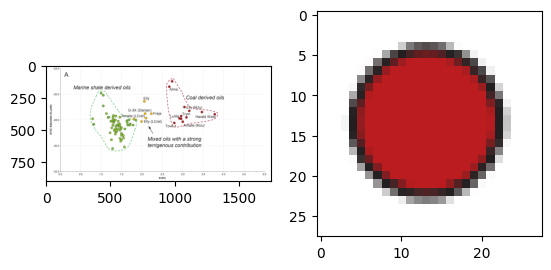

In [65]:
plt.subplot(1, 2, 1)
draw_image(source_image)

plt.subplot(1, 2, 2)
draw_image(template_rgb)

([], [])

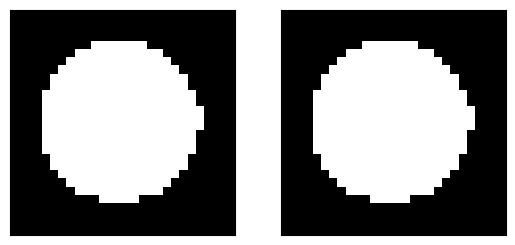

In [66]:
TRESHOLD_VALUE = 210
template_mask = template_tresholding(template_rgb, TRESHOLD_VALUE)
new_template_mask = reconstruct_template_mask(template_mask)

template_mask_rgb = np.zeros((template_mask.shape[0], template_mask.shape[1], 3))
template_mask_rgb[:, :, 0] = template_mask
template_mask_rgb[:, :, 1] = template_mask
template_mask_rgb[:, :, 2] = template_mask

fig = plt.figure()
plt.subplot(1, 2, 1)
draw_image(template_mask)
plt.xticks([]); plt.yticks([])

plt.subplot(1, 2, 2)
draw_image(new_template_mask)
plt.xticks([]); plt.yticks([])

**Replace black pixels**

In [67]:
image = replace_black_pixels(source_image)
template = replace_black_pixels(template_rgb)

DEBUG - template_match.py - replace_black_pixels: Number of black pixels on image: 0
DEBUG - template_match.py - replace_black_pixels: Number of black pixels on image: 0


**Image tresholding**

In [68]:
MASK_VALUE = 0

image_mask = template_tresholding(image, treshold=TRESHOLD_VALUE)
indexes_background = np.where(image_mask == 0)
image_with_mask = np.copy(image)
image_with_mask[indexes_background] = MASK_VALUE

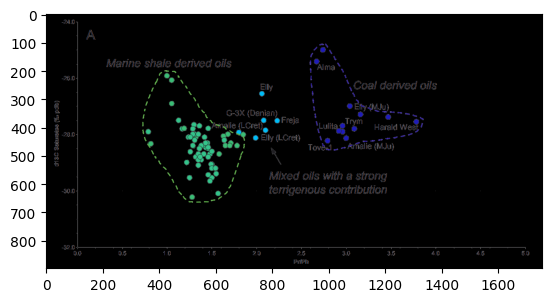

In [69]:
plt.imshow(image_with_mask)

**Binary masks**

In [70]:
assert np.all(np.unique(template_mask) == np.array([0, 255]))
assert np.all(np.unique(image_mask) == np.array([0, 255]))
assert len(template_mask.shape) == 2
assert len(image_mask.shape) == 2

template_mask_binary = template_mask / 255
image_mask_binary = image_mask / 255

template_non_mask_pixels_count = np.sum(template_mask_binary)

In [71]:
# imshow_interactive(image_mask_binary)

In [72]:
# mask_part = get_image_part(304, 434, image_mask_binary, w_template, h_template)
# imshow_interactive(mask_part)

In [73]:
# imshow_interactive(template_mask_binary)

In [74]:
# imshow_interactive(mask_part * template_mask_binary)

In [75]:
# compute_mask_pixel_ratio_v2(mask_part, template_mask_binary, np.sum(template_mask_binary))

In [76]:
# # method_name = 'SOME_CUSTOM_METHOD'
# method = "cv.TM_SQDIFF_NORMED"

# corr_map, _ = template_match(image, template_rgb, template_mask, method)
# corr_map2, _ = template_match(image, template_rgb, new_template_mask, method)

# corr_map3 = corr_map + 0.5 * corr_map2

In [77]:
# method_name = "CUSTOM_SQDIFF"

corr_map_height = h_image - h_template + 1
corr_map_width = w_image - w_template + 1
corr_map = np.zeros((corr_map_height, corr_map_width), dtype=np.float64)

image = image.astype(np.float64)
template = template.astype(np.float64)
template_mask_rgb = template_mask_rgb.astype(np.float64)

for y in tqdm(range(corr_map_height)):
    for x in range(corr_map_width):
        image_part = get_image_part(y, x, image, w_template, h_template)
        image_mask_part_binary = get_image_part(y, x, image_mask_binary, w_template, h_template)

        # corr_value = sqdiff_normed(image_part, template, template_mask_rgb)
        corr_value = sqdiff_normed_modification(
            image_part,
            template,
            template_mask_rgb,
            image_mask_part_binary,
            template_mask_binary,
            template_non_mask_pixels_count,
            ratio_treshold=0.8
        )
        corr_map[y, x] = corr_value

  0%|          | 0/871 [00:00<?, ?it/s]

In [78]:
corr_map2 = np.copy(corr_map)
corr_map2 = invert_convolution_map(corr_map2)

In [79]:
nan_indexes = np.where( np.isnan(corr_map) )
inf_indexes = np.where( np.isinf(corr_map) )
print("Number of NaN values:", len(nan_indexes[0]))
print("Number of inf values:", len(inf_indexes[0]))

corr_map2[nan_indexes] = 0
corr_map2[inf_indexes] = 0

corr_map2 = normalize_map(corr_map2)

Number of NaN values: 1498833
Number of inf values: 0


In [83]:
# imshow_interactive(corr_map)

In [84]:
# imshow_interactive(corr_map2)

In [82]:
MAXIMUMS_NUMBER_LIMIT = 200


@interact(N_maximums=widgets.FloatSlider(value=1, min=1, max=MAXIMUMS_NUMBER_LIMIT, step=1),
          eps=widgets.FloatSlider(value=0.1, min=0.1, max=10, step=0.1))
def visualize(N_maximums, eps):

    ## get max points
    N_maximums = int(N_maximums)
    maximums = get_first_N_maximums(corr_map2, N_maximums)
    y_points = np.array( [pt[1][0] for pt in maximums] )
    x_points = np.array( [pt[1][1] for pt in maximums] )
    points = np.stack((x_points, y_points)).T

    ## clustering
    cluster_labels = meanshift_clustering(points, eps)
    # cluster_labels = agglomerative_clustering(points, eps)
    actual_points = simplify_points(points, cluster_labels)
    x = actual_points[:, 0]
    y = actual_points[:, 1]

    ## founded points on original image
    plt.figure(figsize=(9, 9))
    draw_image(source_image)
    x += w_template // 2
    y += h_template // 2
    plt.scatter(x, y, s=50, c="yellow", marker="*",  edgecolors='black', linewidths=0.2)
    # plt.xticks([]); plt.yticks([]);
    plt.title(f"{N_maximums=}")
    plt.show()
    
    ## founded points on clear canvas
    plt.figure(figsize=(10, 6))
    draw_points_on_canvas(actual_points, source_image)

interactive(children=(FloatSlider(value=1.0, description='N_maximums', max=200.0, min=1.0, step=1.0), FloatSli…